In [1]:
import math
from math import floor

from typing import Any, Dict, List, Optional, Union

import torch
from typing_extensions import TypedDict
import time
import csv
from random import randint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from tqdm.notebook import trange, tqdm

from mapie._typing import NDArray
from mapie.classification import MapieClassifier
from mapie.metrics import (classification_coverage_score_v2,
                           classification_mean_width_score)

from data.data_generation import create_artificial_data, load_beans_data

In [2]:
random_state=randint(0, 100000)
data = create_artificial_data(n_features=20, n_classes=5, sample_size=10000, random_stat=random_state).to_numpy()
#data, _ = load_beans_data()
#data = data.to_numpy()
# new datapoints for evaluation of conformal
#X_train, X_new, y_train, y_new = train_test_split(np.delete(data, -1, axis=1), data[:,-1], train_size=5000, random_state=random_state)

d_train, d_new = train_test_split(data, stratify=data[:,-1], train_size=5000, random_state=random_state)
X_train, X_new, y_train, y_new = np.delete(d_train, -1, axis=1), np.delete(d_new, -1, axis=1), d_train[:,-1], d_new[:,-1]

# Evaluate differences between splits

In [3]:
# split training data so artificially reduce the training set size
train_size = len(X_train)-1
X_eff_train, X_drop, y_eff_train, y_drop = train_test_split(X_train, y_train, train_size=train_size, random_state=random_state)

In [41]:
models = {"GaussianNB" : GaussianNB,
          "SVM" : lambda : SVC(gamma='auto', probability=True)}
methods = ["lac", "aps"] # adaptive and non-adaptive implementation
alpha = 0.05

# CrossValidation split, split conformal is identical to using only 2 splits
kf = KFold(n_splits=5, shuffle=True, random_state=random_state)
clfs, mapies, covs, setsizes = {}, {}, {}, {}
for modelname, modeltyp in models.items():
    clfs_, mapies_, covs_, setsizes_ = {}, {}, {}, {}
    for method in methods:
        clfs__, mapies__, covs__, setsizes__ = {}, {}, {}, {}
        for fold, (train_idx, calib_idx) in enumerate(kf.split(X_eff_train)):
            clf = modeltyp().fit(X_eff_train[train_idx, :], y_eff_train[train_idx])
            clfs__[fold] = clf
            mapie = MapieClassifier(estimator=clf, cv="prefit", method=method)
            mapie.fit(X_train[calib_idx], y_train[calib_idx])
            mapies__[fold] = mapie
            
            y_pred_mapie, y_ps_mapie = mapie.predict(
                X_new, alpha=alpha, include_last_label="randomized")
            
            cov = classification_coverage_score_v2(y_new.astype(int), np.squeeze(y_ps_mapie))
            setsize = classification_mean_width_score(np.squeeze(y_ps_mapie))
            covs__[fold], setsizes__[fold] = cov, setsize
            
        clfs_[method] =  clfs__
        mapies_[method] = mapies__
        covs_[method] = covs__
        setsizes_[method] = setsizes__
        
    clfs[modelname] =  clfs_
    mapies[modelname] = mapies_
    covs[modelname] = covs_
    setsizes[modelname] = setsizes_

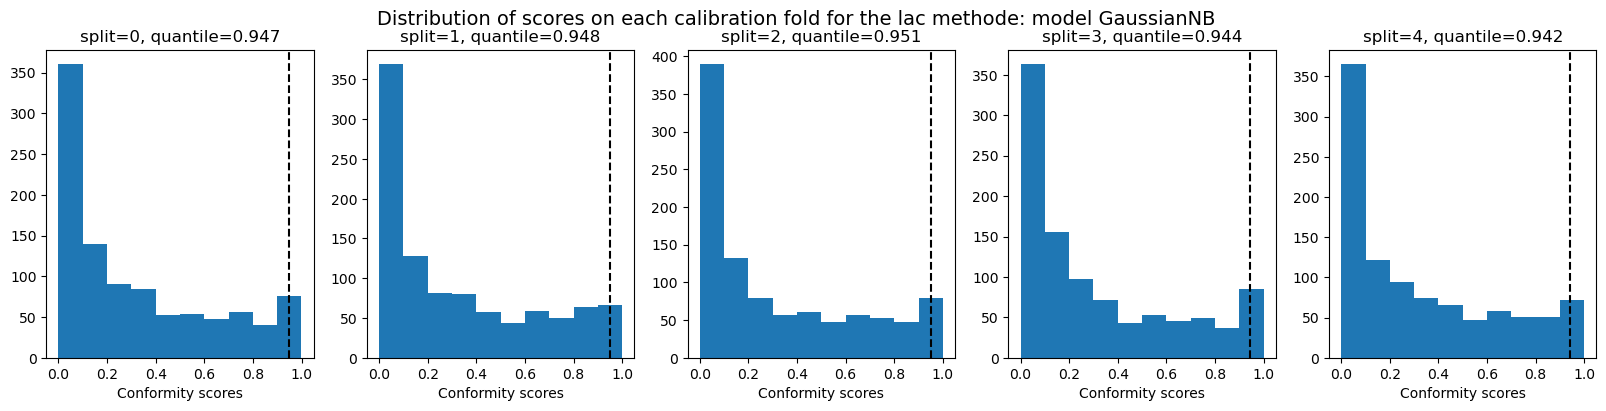

In [45]:
results = mapies["GaussianNB"]
#results = mapies["SVM"]
fig, axs = plt.subplots(1, len(results["lac"]), figsize=(20, 4))
for i, (key, mapie) in enumerate(results["lac"].items()):
    axs[i].set_xlabel("Conformity scores")
    axs[i].hist(mapie.conformity_scores_)
    axs[i].axvline(mapie.quantiles_[0], ls="--", color="k")
    axs[i].set_title(f"split={key}, quantile={mapie.quantiles_[0]:.3f}")
plt.suptitle(
        "Distribution of scores on each calibration fold for the "
        f"{methods[0]} methode: model GaussianNB\n", fontsize=14)
plt.savefig("results/influence_diff_split_gaus_lac")
plt.show()

# Evaluate the influence of different methods

In [3]:
Params = TypedDict(
    "Params",
    {
        "method": str,
        "cv": Optional[Union[int, str]],
        "random_state": Optional[int]
    }
)
ParamsPredict = TypedDict(
    "ParamsPredict",
    {
        "include_last_label": Union[bool, str],
        "agg_scores": Optional[str]
    }
)

num_splits = 5
kf_cv = KFold(n_splits=num_splits, shuffle=True)

STRATEGIES = {
    "lac_split": (
        Params(method="lac", cv="prefit", random_state=42),
        ParamsPredict(include_last_label=False)
    ),
    "lac_cv+_mean": (
        Params(method="lac", cv=kf_cv, random_state=42),
        ParamsPredict(include_last_label=False, agg_scores="mean")
    ),
    "lac_cv+_crossval": (
        Params(method="lac", cv=kf_cv, random_state=42),
        ParamsPredict(include_last_label=False, agg_scores="crossval")
    ),
     "lac_jackknife+_crossval": (
        Params(method="lac", cv="jackknife", random_state=42),
        ParamsPredict(include_last_label=False, agg_scores="crossval")
    ),
    "aps_split": (
        Params(method="aps", cv="prefit", random_state=42),
        ParamsPredict(include_last_label="randomized")
    ),
    "aps_cv+_mean": (
        Params(method="aps", cv=kf_cv, random_state=42),
        ParamsPredict(include_last_label="randomized", agg_scores="mean")
    ),
    "aps_cv+_crossval": (
        Params(method="aps", cv=kf_cv, random_state=42),
        ParamsPredict(include_last_label='randomized', agg_scores="crossval")
    ),
    "aps_jackknife+_crossval": (
        Params(method="aps", cv="jackknife", random_state=42),
        ParamsPredict(include_last_label='randomized', agg_scores="crossval")
    )
}

STRATEGIES_TEST = {
    "aps_jackknife+_crossval": (
        Params(method="aps", cv="jackknife", random_state=42),
        ParamsPredict(include_last_label='randomized', agg_scores="crossval")
    )
}

STRATEGIES_RF_VS_ACC = {
    "lac_split": (
        Params(method="lac", cv="prefit", random_state=42),
        ParamsPredict(include_last_label=False)
    ),
    "aps_split": (
        Params(method="aps", cv="prefit", random_state=42),
        ParamsPredict(include_last_label="randomized")
    ),
}

In [ ]:
#models = {"GaussianNB" : lambda : make_pipeline(StandardScaler(), GaussianNB()),
#          "SVM" : lambda : make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True))}
models = {"GaussianNB" : lambda : make_pipeline(StandardScaler(), GaussianNB()),
          "SVM" : lambda : make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True)),
          "RF" : lambda : make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=100))}
#models = {"RF" : lambda : make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=150))}
alpha = 0.1
num_classes = 5
steps = 1 # for dataset splits
start_training_points = 5 #100 (at least num(classes))
max_training_points = 200 #len(X_train)-1
strategies = STRATEGIES # STRATEGIES_RF_VS_ACC #STRATEGIES_TEST 
dataset = "artificial"
experiment = "200dp"
num_repeats = 2

for repeats in trange(2, 10):    
    result_file = 'results/' + dataset + '/' + experiment + '/Cv_Split_Evaluation_' + str(repeats) + '.csv'
    #result_file = 'results/' + dataset + '/RF_conformal_vs_acc_' + str(repeats) + '.csv'
    with (open(result_file, 'a', newline='') as csvfile):
        fieldnames = ['model', 'strategy', "training_size", "coverage", "set_size", "acc", "duration"]
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
    
        covs, setsizes = {}, {}
        for modelname, modeltyp in tqdm(models.items(), desc="Model"):
            covs_, setsizes_ = {}, {}
            for strategy, params in tqdm(strategies.items(), desc="Strategy"):
                args_init, args_predict = strategies[strategy]
                covs__, setsizes__ = {}, {}
                for training_set_size in trange(start_training_points, max_training_points, steps):
                    random_state=randint(0, 6666666)
                    
                    print("Train ", modelname, " - ", strategy, " train size ", training_set_size)
                    start_time = time.monotonic()
                    
                    # split training data so artificially reduce the training set size
                    X_eff_train, _, y_eff_train, _ = train_test_split(X_train, y_train, train_size=training_set_size, random_state=random_state, stratify=y_train)
                    # at least required datapoints
                    if len(X_eff_train) < 1/alpha + 1 + num_classes:
                        continue
                    
                    # binaray classification allows not for aps
                    if args_init['method'] == "aps":
                        continue
                    
                    # fit model and calibrate
                    if args_init['cv'] == "prefit":
                        #check if 20% of X_eff_train > 1(1-alpha)
                        # requires at least 11 samples in the calibration set and num_classes examples in the training set
                        if 0.2*len(X_eff_train) > 1/alpha:
                            X_train_, X_calib_, y_train_, y_calib_ = train_test_split(X_eff_train, y_eff_train, train_size=0.8, random_state=random_state, stratify=y_eff_train)
                        else:
                            X_train_, X_calib_, y_train_, y_calib_ = train_test_split(X_eff_train, y_eff_train, train_size=X_eff_train.shape[0]-(floor(1/alpha) + 1), random_state=random_state, stratify=y_eff_train)
                        
                        clf = modeltyp().fit(X_train_, y_train_)
                        mapie_clf = MapieClassifier(estimator=clf, **args_init)
                        mapie_clf.fit(X_calib_, y_calib_)
                            
                    elif args_init['cv'] == "jackknife":
                        # jackknife+ k=n
                        args_init["cv"] = KFold(n_splits=len(X_eff_train), shuffle=True)
                        mapie_clf = MapieClassifier(estimator=modeltyp(), **args_init)
                        mapie_clf.fit(X_eff_train, y_eff_train)
                        
                    else:    
                        # CV+ with k=5         
                        #print(len(X_eff_train), " " , args_init["cv"].n_splits)
                        mapie_clf = MapieClassifier(estimator=modeltyp(), **args_init)
                        mapie_clf.fit(X_eff_train, y_eff_train)
                    
                    end_time = time.monotonic()
                    elapsed_time = end_time - start_time
                    
                    # prediction    
                    y_pred, y_ps = mapie_clf.predict(X_new, alpha=alpha, **args_predict)
                    acc_model = accuracy_score(y_new, y_pred)
    
                    #covs__[training_set_size] = classification_coverage_score(y_new.astype(int), np.squeeze(y_ps))
                    #setsizes__[training_set_size] = classification_mean_width_score(np.squeeze(y_ps))
                    writer.writerow({'model' : modelname,
                                     'strategy' : strategy,
                                     "training_size": training_set_size,
                                     "coverage" : classification_coverage_score_v2(y_new.astype(int), np.squeeze(y_ps))[0],
                                     "set_size" : classification_mean_width_score(np.squeeze(y_ps)),
                                     "acc" : acc_model, 
                                     "duration" : elapsed_time})
                
                #covs_[strategy], setsizes_[strategy] = covs__, setsizes__
            
            #covs[modelname] = covs_
            #setsizes[modelname] = setsizes_

In [6]:
import matplotlib._color_data as mcd
def plot_exp(plt_type : str, data_mean : pd.DataFrame, data_std : pd.DataFrame, methode="aps", model="GaussianNB", quiet=False, dataset="beans", experiment="200dp") ->Optional[None]:
    plt.figure(figsize=(8, 6))
    data_mean = data_mean.loc[data_mean['model'] == model, :]
    data_std = data_std.loc[data_std['model'] == model, :]
    
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'royalblue', 'limegreen', 'tab:cyan', 'coral', 'fuchsian']
    
    for i, strategy in enumerate(data_mean['strategy'].unique()):
        strat_data_mean = data_mean.loc[data_mean['strategy'] == strategy, :]
        strat_data_std = data_std.loc[data_std['strategy'] == strategy, :]
        X = strat_data_mean['training_size']
        plt.plot(X, strat_data_mean[plt_type], label=strategy, linestyle='-', 
                    color=colors[i%4])
        plt.fill_between(X, strat_data_mean[plt_type]-strat_data_std[plt_type], 
                             strat_data_mean[plt_type]+strat_data_std[plt_type],
                             color=colors[i%4],
                             alpha=0.05)
        
    fontsize_x = 20
    fontsize_y = 20
    fontsize_title = 20
    plt.xlabel('Training set size', fontsize=fontsize_x)
    if plt_type == "duration":
        plt.ylabel("Training time [s]", fontsize=fontsize_y)
        plt.title(model + '\nDataset \"' + dataset + "\"" +', alpha=' + str(alpha), fontsize=fontsize_title)
    elif plt_type == "set_size":
        plt.ylabel("Prediction set size", fontsize=fontsize_y)
        plt.title(model + '\nDataset \"' + dataset + "\"" +', alpha=' + str(alpha), fontsize=fontsize_title)
    elif plt_type == "acc":
        plt.ylabel("Accuracy", fontsize=fontsize_y)
        plt.title(model + '\nDataset \"' + dataset + "\"" +', alpha=' + str(alpha), fontsize=fontsize_title)
    else:
        plt.ylabel(plt_type, fontsize=fontsize_y)
        plt.title(model + '\nDataset \"' + dataset + "\"" +', alpha=' + str(alpha), fontsize=fontsize_title)
    plt.legend(fontsize=14)
    plt.grid(True)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=12)
    if not quiet:
        plt.show()
        return plt
    else:
        plt.savefig("results/" + dataset + "/" + experiment + "/figure/" + model + "_" + methode + "_" + experiment + "_" +plt_type)
        return None

Finished


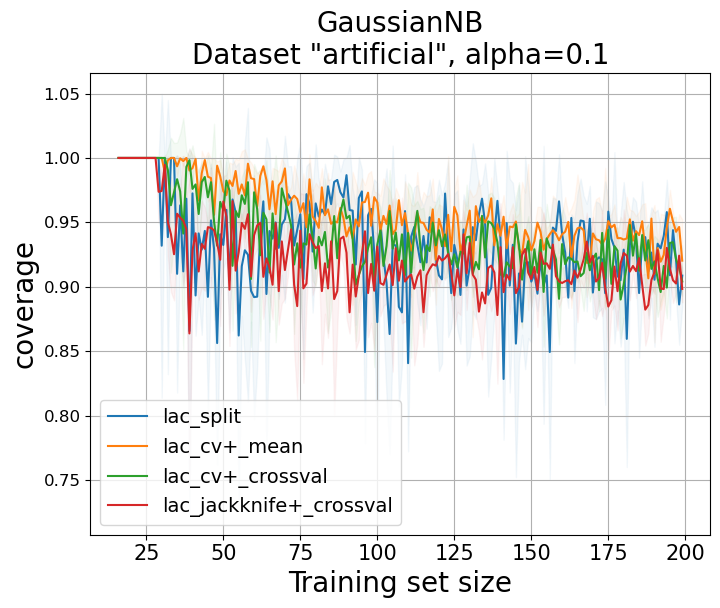

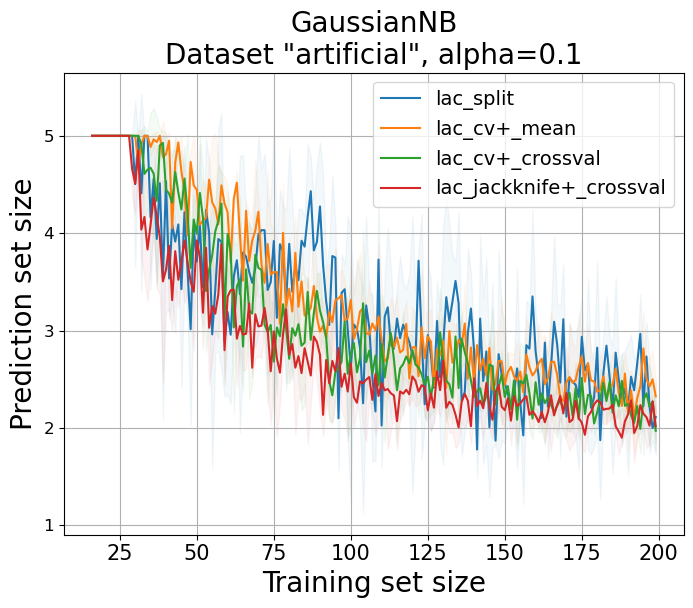

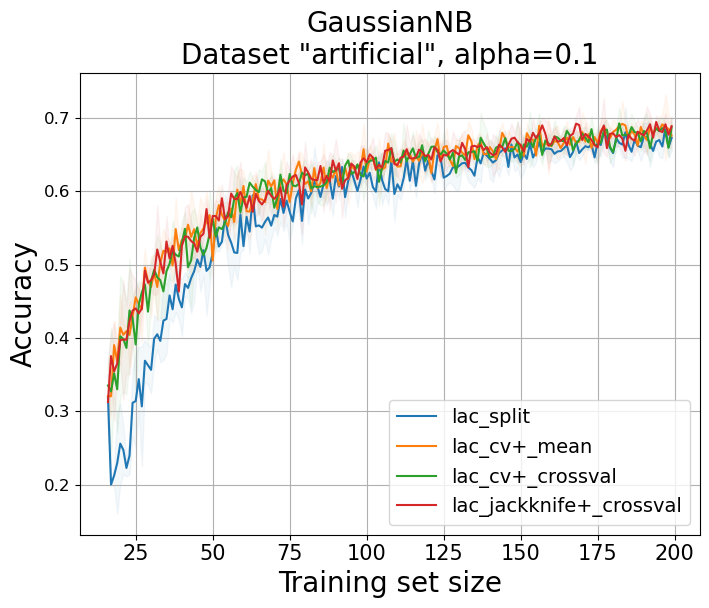

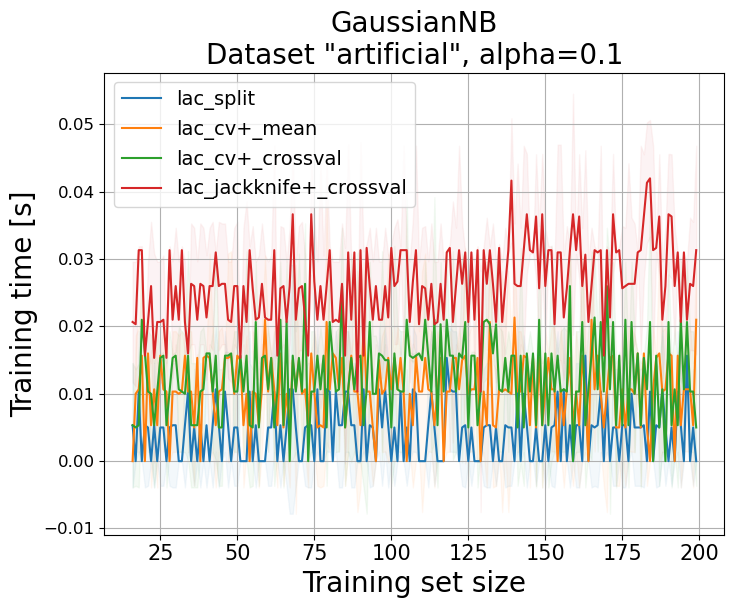

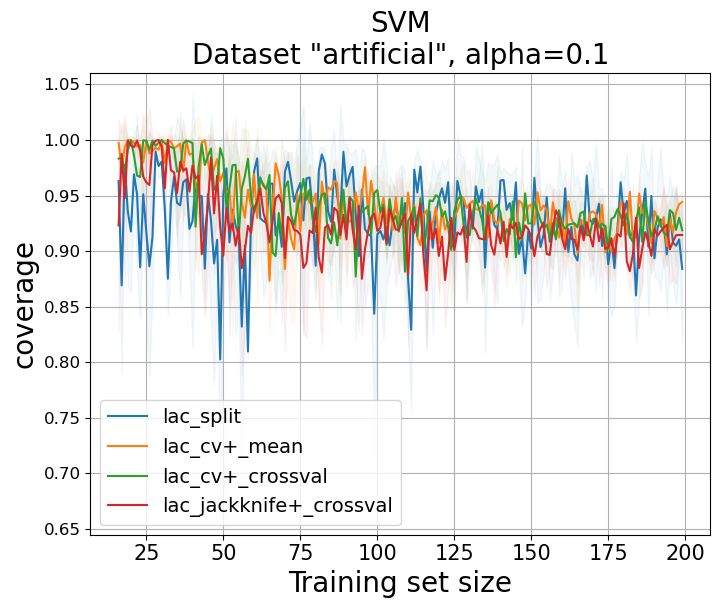

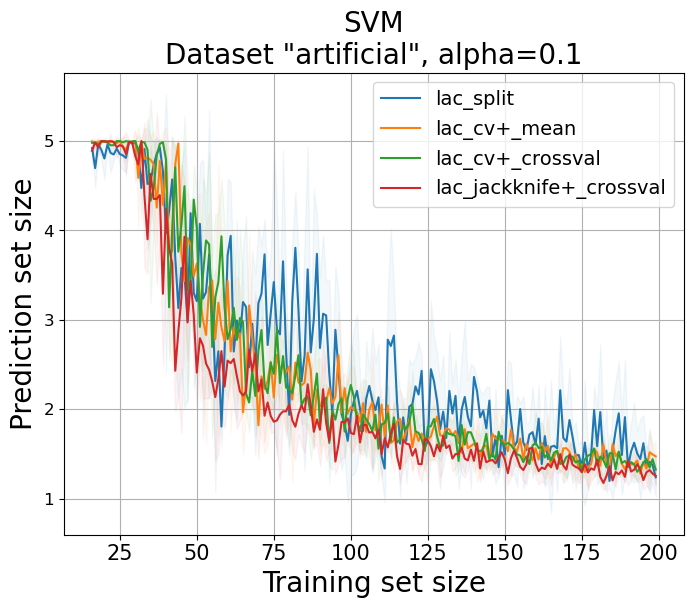

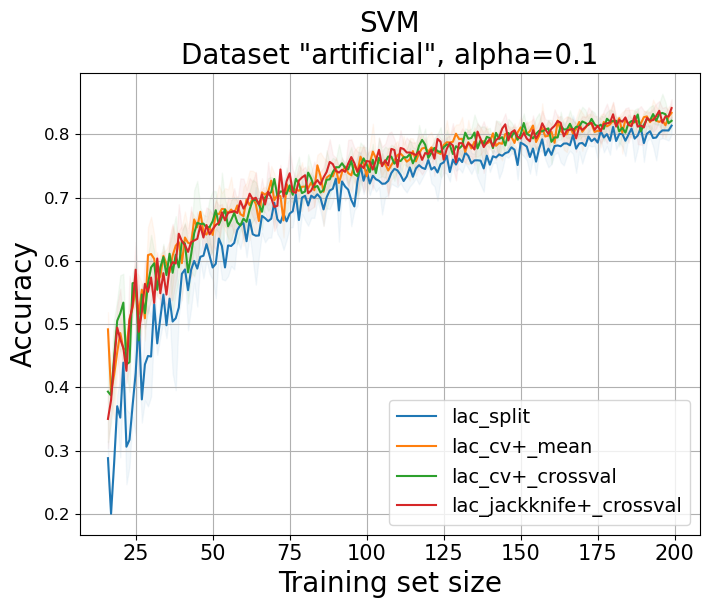

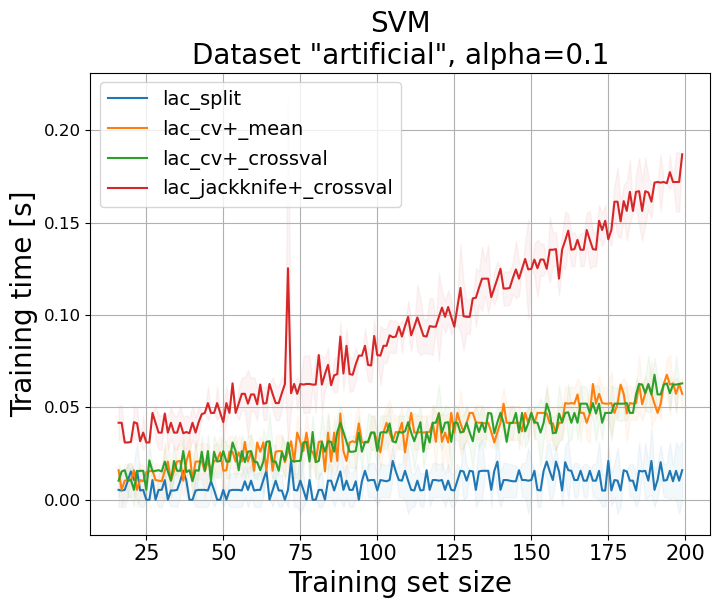

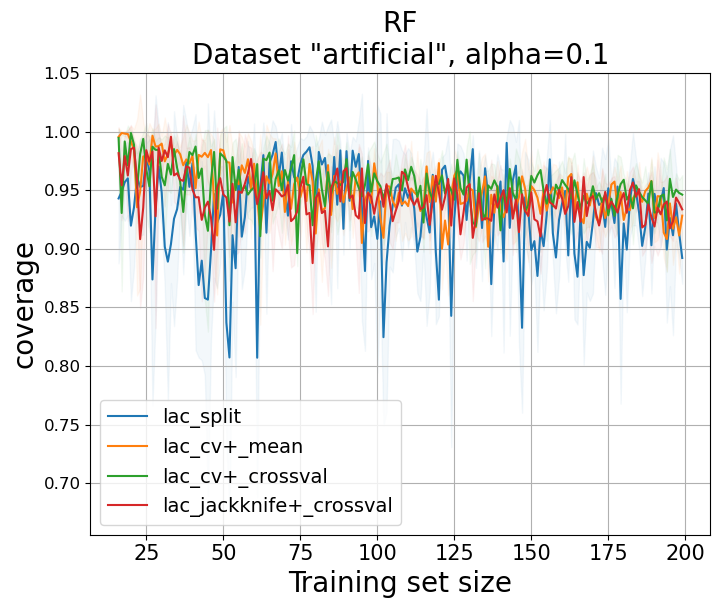

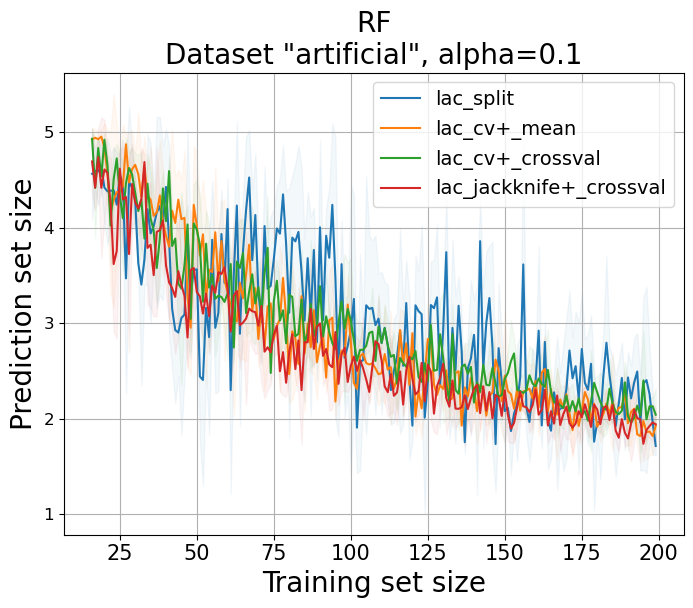

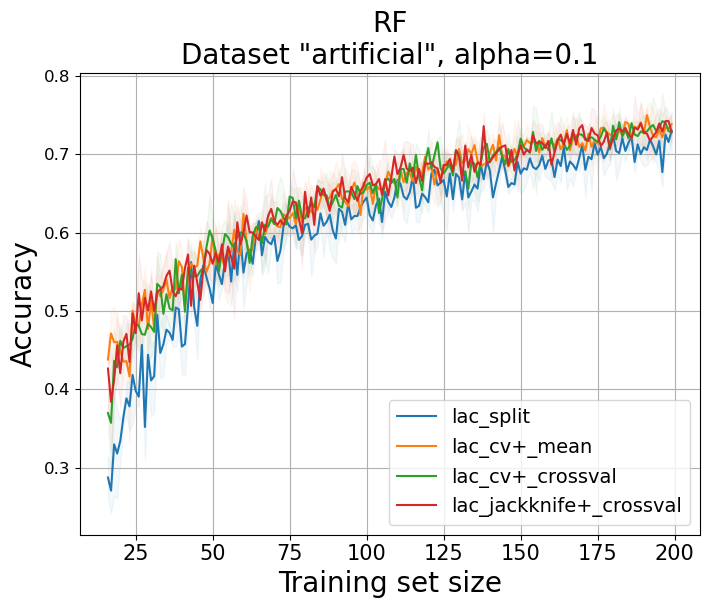

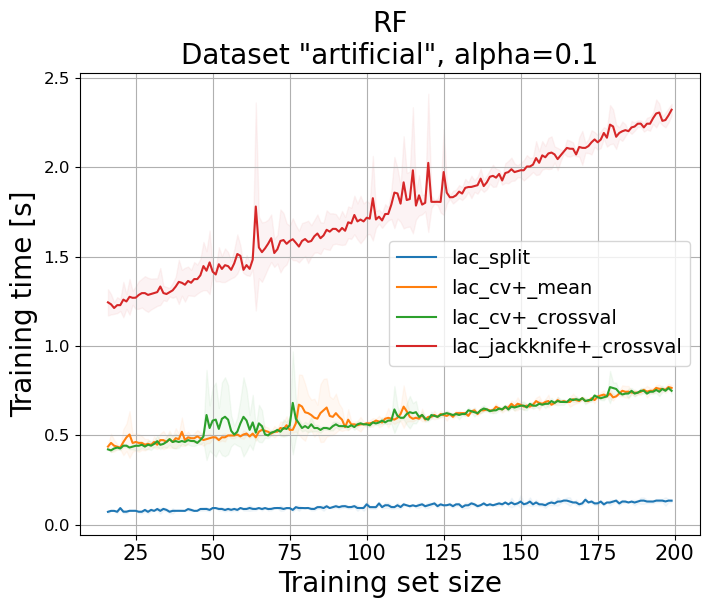

In [8]:
alpha = 0.1
#exp_data = pd.read_csv('results/Cv_Split_Evaluation_4.csv')
results = []
#dataset = "beans"
dataset = "artificial"
experiment = "200dp"

for i in range(0,3):
    results.append(pd.read_csv('results/' + dataset + "/" + experiment + '/Cv_Split_Evaluation_' + str(i) + '.csv').iloc[:,2:])
exp_data_mean = sum(results) / len(results)
exp_data_std = pd.DataFrame(torch.tensor(np.dstack(results)).std(dim=2))
col_1_2 = pd.read_csv('results/' + dataset + "/" + experiment + '/Cv_Split_Evaluation_0.csv').iloc[:,0:2]
exp_data_mean = pd.concat([col_1_2, exp_data_mean], axis=1)
exp_data_std = pd.concat([col_1_2, exp_data_std], axis=1)
exp_data_std.columns = exp_data_mean.columns

import itertools
model_l = ["GaussianNB", "SVM", "RF"]
plt_type = ["coverage", "set_size", "acc", "duration"]
#methods = ["aps", "naive"]
methods = ["naive"]
for (model, pt, met) in list(itertools.product(model_l, plt_type, methods)):
    plot_exp(plt_type = pt, data_mean=exp_data_mean, data_std= exp_data_std, experiment=experiment, methode=met, model=model, quiet=True, dataset=dataset)
print("Finished")

# Plotting the RF vs conformal

In [100]:
import matplotlib._color_data as mcd
def plot_RF_vs_acc(data_mean : pd.DataFrame, data_std : pd.DataFrame, model="RF", quiet=False, dataset="artificial", alpha=0.9) ->Optional[None]:
    plt.figure(figsize=(8, 6))
    data_mean = data_mean.loc[data_mean['model'] == model, :]
    data_std = data_std.loc[data_std['model'] == model, :]
    
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'royalblue', 'limegreen', 'tab:cyan', 'coral', 'fuchsian']
    
    for i, strategy in enumerate(data_mean['strategy'].unique()):
        for (t,type) in enumerate(["coverage", "acc"]):
            strat_data_mean = data_mean.loc[data_mean['strategy'] == strategy, :]
            strat_data_std = data_std.loc[data_std['strategy'] == strategy, :]
            X = strat_data_mean['training_size']
            if type == "acc":
                plt.plot(X, strat_data_mean[type], label="accuracy", linestyle='-', 
                        color=colors[t%4])
            else:
                plt.plot(X, strat_data_mean[type], label=type, linestyle='-', 
                        color=colors[t%4])
            plt.fill_between(X, strat_data_mean[type]-strat_data_std[type], 
                                 strat_data_mean[type]+strat_data_std[type],
                                 color=colors[t%4],
                                 alpha=0.15)
        
    fontsize_x = 20
    fontsize_y = 15
    fontsize_title = 20
    plt.xlabel('Training set size', fontsize=fontsize_x)

    plt.ylabel("accuracy/empirical coverage", fontsize=fontsize_y)
    plt.title(model + '\nDataset \"' + dataset + "\"" +', alpha=' + str(alpha), fontsize=fontsize_title)

    plt.legend(fontsize=14)
    plt.grid(True)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=12)
    if not quiet:
        plt.show()
        return plt
    else:
        plt.savefig("results/" + dataset + "/RF_conformal_vs_acc/" + "figure")
        return None

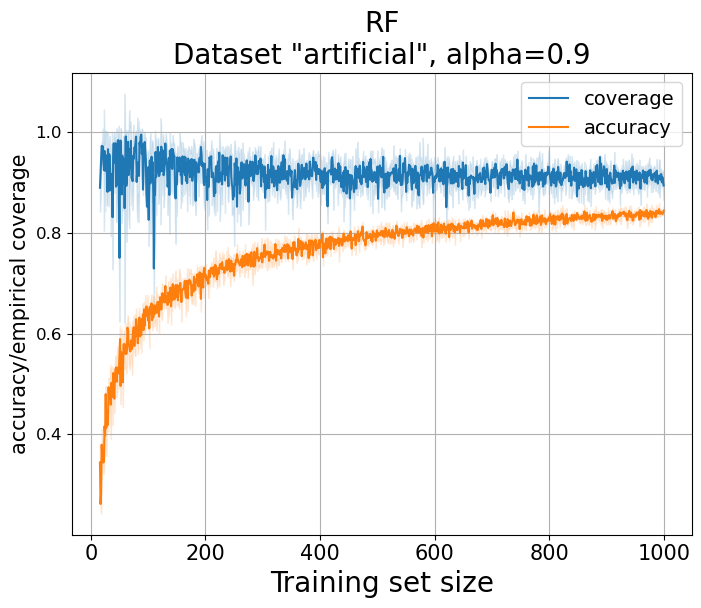

In [101]:
results = []
for i in range(0,3):
    results.append(pd.read_csv('results/artificial/RF_conformal_vs_acc/RF_conformal_vs_acc_' + str(i) + '.csv').iloc[:,2:])
exp_data_mean = sum(results) / len(results)
exp_data_std = pd.DataFrame(torch.tensor(np.dstack(results)).std(dim=2))   
col_1_2 = pd.read_csv('results/artificial/RF_conformal_vs_acc/RF_conformal_vs_acc_0.csv').iloc[:,0:2]
exp_data_mean = pd.concat([col_1_2, exp_data_mean], axis=1)
exp_data_std = pd.concat([col_1_2, exp_data_std], axis=1)
exp_data_std.columns = exp_data_mean.columns

plot_RF_vs_acc(data_mean=exp_data_mean, data_std= exp_data_std, quiet=True, dataset=dataset, alpha=0.9)

In [77]:
exp_data_mean[['coverage','acc']]

,coverage,acc
0,0.889600,0.343933
1,0.915733,0.261267
2,0.941600,0.282867
3,0.972467,0.379200
4,0.968333,0.355000
...,...,...
979,0.916667,0.838667
980,0.900400,0.838333
981,0.910400,0.837133
982,0.901867,0.839333


# Thrash code

In [ ]:
models = {"SVM" : lambda : make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True))}

alpha = 0.05
X_train, X_drop, y_train, y_drop = train_test_split(np.delete(data, -1, axis=1), data[:,-1], train_size=5000, random_state=random_state)
X_calib, X_new, y_calib, y_new = train_test_split(X_drop, y_drop, train_size=1000, random_state=random_state)
svm = models['SVM']()
svm.fit(X_train, y_train)
svm_mapie = MapieClassifier(estimator=svm, method="aps", cv="prefit", random_state=42)
svm_mapie.fit(X_calib, y_calib)

y_pred = svm.predict(X_new)
acc_model = accuracy_score(y_new, y_pred)
print("acc_model : ", acc_model)

y_pred, y_ps = svm_mapie.predict(X_new, alpha=alpha, include_last_label="randomized")
acc_mapie = accuracy_score(y_new, y_pred)
print("acc_mapie : ", acc_mapie)
print("cov : ", classification_coverage_score_v2(y_new.astype(int), np.squeeze(y_ps)))
print("set_size: ", classification_mean_width_score(np.squeeze(y_ps)))

plot_exp(plt_type = "coverage", data=exp_data, methode="aps", model="GaussianNB")
plot_exp(plt_type = "duration", data=exp_data, methode="aps", model="GaussianNB")
plot_exp(plt_type = "set_size", data=exp_data, methode="aps", model="GaussianNB")
plot_exp(plt_type = "acc", data=exp_data, methode="aps", model="GaussianNB")